In [18]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# use resnet50 as the base model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from PIL import Image


In [19]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None:
            img = img.resize((224, 224))  # Resize the image
            img = img.convert('RGB')  # Convert image to RGB
            images.append(np.array(img))
    return images

# load the images into a single array from the TRAIN_1 folder containg 2 subfolders containing 500 images each
train_images = []
for i in range(2):
    train_images.extend(load_images_from_folder('TRAIN_1/{}'.format(i)))  # Use extend instead of append

train_images = np.array(train_images)
print(train_images.shape)

train_labels = np.array([0] * 500 + [1] * 500)
train_labels = to_categorical(train_labels)

(1000, 224, 224, 3)


In [20]:

# setup the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from ResNet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 165 layers and unfreeze the rest:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 resnet blocks
# alongside the top Dense layers
model.fit(train_images, train_labels ,epochs=10, batch_size=32, verbose=1)

# save the model
model.save('model.h5')

# load the model
model = tf.keras.models.load_model('model.h5')



Epoch 1/10


32/32 [==============================] - 62s 2s/step - loss: 1.0985 - accuracy: 0.7470
Epoch 2/10
32/32 [==============================] - 54s 2s/step - loss: 0.2168 - accuracy: 0.9110
Epoch 3/10
32/32 [==============================] - 51s 2s/step - loss: 0.1381 - accuracy: 0.9500
Epoch 4/10
32/32 [==============================] - 51s 2s/step - loss: 0.0786 - accuracy: 0.9840
Epoch 5/10
32/32 [==============================] - 52s 2s/step - loss: 0.0447 - accuracy: 0.9940
Epoch 6/10
32/32 [==============================] - 51s 2s/step - loss: 0.0253 - accuracy: 0.9960
Epoch 7/10
32/32 [==============================] - 51s 2s/step - loss: 0.0121 - accuracy: 0.9990
Epoch 8/10
32/32 [==============================] - 51s 2s/step - loss: 0.0071 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 51s 2s/step - loss: 0.0049 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 51s 2s/step - loss: 0.0034 - accuracy: 1.0000


Epoch 1/10
32/32 [==============================] - 61s 2s/step - loss: 0.0060 - accuracy: 1.0000
Epoch 2/10
32/32 [==============================] - 56s 2s/step - loss: 0.0027 - accuracy: 1.0000
Epoch 3/10
32/32 [==============================] - 55s 2s/step - loss: 0.0013 - accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 55s 2s/step - loss: 0.0010 - accuracy: 1.0000
Epoch 5/10
32/32 [==============================] - 56s 2s/step - loss: 7.2454e-04 - accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 60s 2s/step - loss: 5.9054e-04 - accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 55s 2s/step - loss: 5.5937e-04 - accuracy: 1.0000
Epoch 8/10
32/32 [==============================] - 54s 2s/step - loss: 4.3900e-04 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 54s 2s/step - loss: 4.1190e-04 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 55s 2s/step - loss: 3.7036e-04 - accuracy: 1.

c:\Users\arnav\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:

# # set up the model
# base_model = ResNet50(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # freeze the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:

# # train the model
# history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

# # plot the training and validation accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'])
# plt.show()

# # plot the training and validation loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'])
# plt.show()

# # save the model
# model.save('dalle_classifier.h5')


(100, 224, 224, 3)
4/4 [==============================] - 8s 1s/step - loss: 0.9706 - accuracy: 0.7200
Test Accuracy: 0.720
4/4 [==============================] - 7s 1s/step
[[7.0942909e-01 2.9057094e-01]
 [8.1578538e-02 9.1842145e-01]
 [9.3304038e-01 6.6959545e-02]
 [9.2896688e-01 7.1033180e-02]
 [9.9999917e-01 8.2171971e-07]
 [9.8184735e-01 1.8152727e-02]
 [9.9443287e-01 5.5671073e-03]
 [9.7154266e-01 2.8457424e-02]
 [9.9904066e-01 9.5931033e-04]
 [1.8288374e-03 9.9817109e-01]
 [9.9983382e-01 1.6609817e-04]
 [2.7475825e-01 7.2524172e-01]
 [3.2348764e-01 6.7651230e-01]
 [9.7711074e-01 2.2889310e-02]
 [8.3474350e-01 1.6525652e-01]
 [1.5469210e-01 8.4530789e-01]
 [8.5713279e-01 1.4286719e-01]
 [9.9961072e-01 3.8935791e-04]
 [8.5874301e-01 1.4125696e-01]
 [9.9554920e-01 4.4508637e-03]
 [3.7576649e-01 6.2423348e-01]
 [9.9993694e-01 6.3081701e-05]
 [4.5423675e-01 5.4576325e-01]
 [3.2136815e-03 9.9678636e-01]
 [6.4260862e-03 9.9357384e-01]
 [2.0400199e-01 7.9599798e-01]
 [9.9887508e-01 1.12

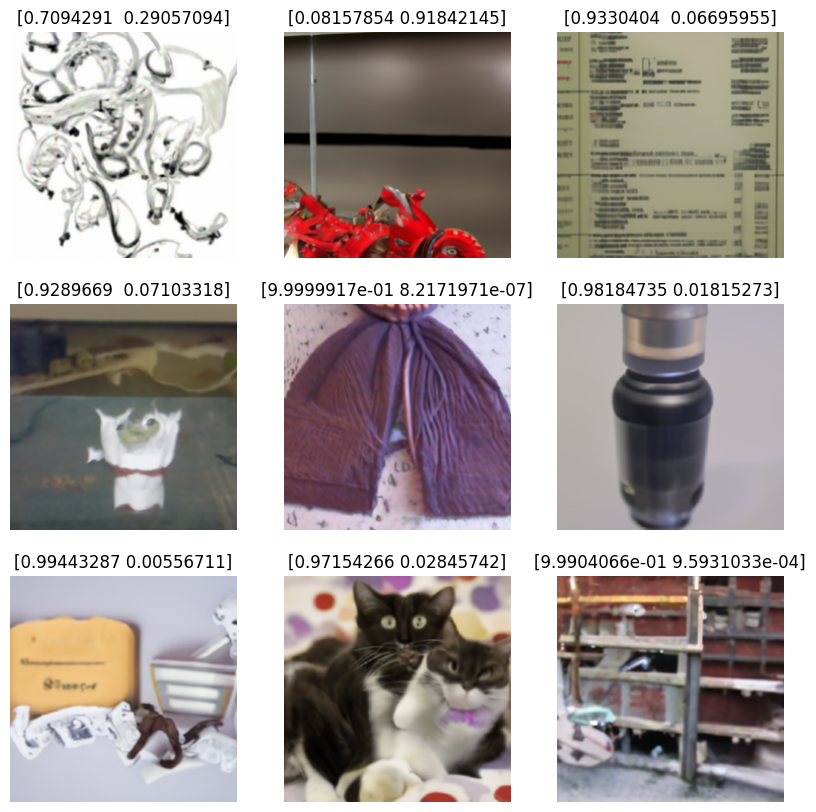

In [25]:

# test the model on a datset of 100 images, 50 of which are labeled as imagenet and 50 of which are labeled as real
test_images = []
for i in range(2):
    test_images.extend(load_images_from_folder('TEST_1/{}'.format(i)))  # Use extend instead of append

test_images = np.array(test_images)
print(test_images.shape)

test_labels = np.array([0] * 50 + [1] * 50)
test_labels = to_categorical(test_labels)

# evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=1)
print('Test Accuracy: %.3f' % acc)

# make a prediction
yhat = model.predict(test_images)
print(yhat)
print(yhat[0])

# show the inputs and predicted outputs
for i in range(len(test_images)):
	print("X=%s, Predicted=%s" % (test_labels[i], yhat[i]))

# plot the first 9 images, their predicted labels, and the true labels
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title('{}'.format(yhat[i]))
    plt.axis('off')
plt.show()
